In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN0-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN4-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN11-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-dir.png
/kag

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [19]:
import os
def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  # If shape is (n, 224, 224)
        X = np.stack([X, X, X], axis=-1)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)
    
    return X_train, X_test, y_train, y_test


In [20]:
# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # Load in color
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype('float32'))  # Use EfficientNet's preprocessing
    return img

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN Model
def build_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the 3D output to 1D
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # For multi-class classification
                  metrics=['accuracy', 'AUC'])  # Tracking accuracy and AUC

    return model

In [22]:
from sklearn.utils.class_weight import compute_class_weight  # deal with imbalance
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Build the model
    model = build_cnn_model(input_shape=(224, 224, 3), num_classes=2)

    # Calculate class weights for imbalanced dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train.flatten()),
        y=y_train.flatten()
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_breast_cancer_model.keras', monitor='val_accuracy',
                                       save_best_only=True, mode='max')

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    # Learning rate reduction
    lr_reduce = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Use both callbacks
    callbacks = [lr_reduce, early_stop, model_checkpoint]

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    # Save the model
    model.save('my_model.h5')

    # Evaluate the model
    result = model.evaluate(X_test, y_test)
    loss, accuracy = result[0], result[1]

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Predict
    y_pred = model.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    print(cm)

    # Compute and print Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test_labels, y_pred_labels)
    print(f"\nCohen's Kappa Score: {kappa:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    return model


In [23]:
# Load and preprocess dataset
print("Loading and preprocessing the dataset...")
X_train, X_test, y_train, y_test = load_dataset() 

Loading and preprocessing the dataset...
Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224, 3)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - AUC: 0.7031 - accuracy: 0.6752 - loss: 26.5716 - val_AUC: 0.9795 - val_accuracy: 0.9416 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - AUC: 0.9852 - accuracy: 0.9346 - loss: 0.1612 - val_AUC: 0.9918 - val_accuracy: 0.9844 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - AUC: 0.9984 - accuracy: 0.9924 - loss: 0.0532 - val_AUC: 0.9940 - val_accuracy: 0.9805 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - AUC: 0.9992 - accuracy: 0.9811 - loss: 0.0393 - val_AUC: 0.9941 - val_accuracy: 0.9844 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - AUC: 0.9995 - accuracy: 0.9873 - loss: 0.0303 - val_AUC: 0.9911 - val_accuracy: 0.9805 - val_loss: 0.1177 - learning_rate: 0.0010
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - AUC: 0.9997 - accuracy: 0.9929 - loss

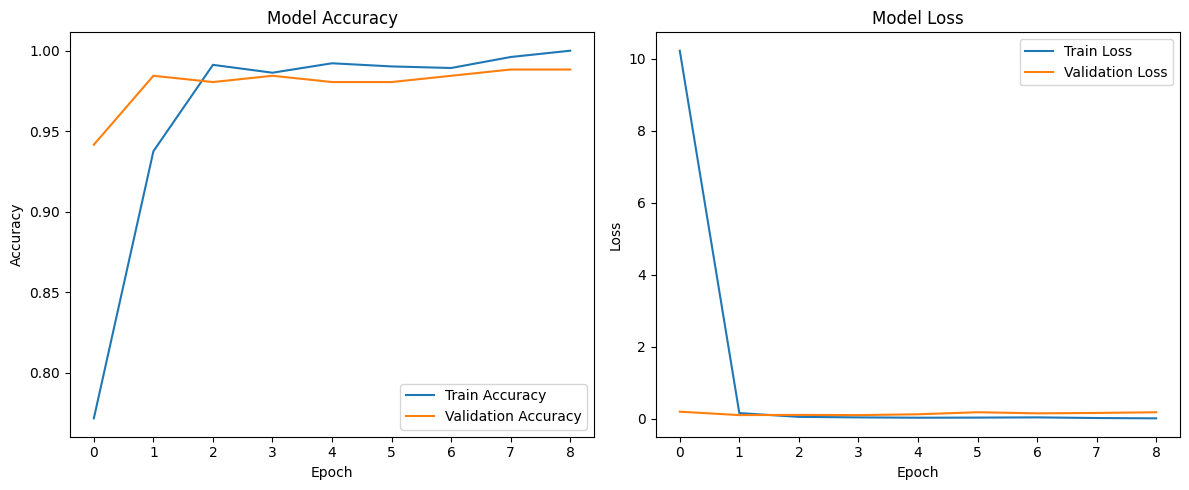

Training and evaluation completed.


In [24]:
 # Train and evaluate the model
print("Training the model...")
model = train_and_evaluate(X_train, X_test, y_train, y_test)
    
print("Training and evaluation completed.")